In [1]:
"""
Author : Saikat Kumar Das (saikat.das1@iiitb.org)
Date   : October 2018
Paper  : Contour and Texture Analysis for Image Segmentation
Status : Work In Progess
Original Filter Bank code by : Tony Joseph (CVDLBOT) [MIT License included]

"""
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy

In [2]:
%matplotlib inline

In [3]:
from skimage import data, segmentation, color
from skimage.future import graph

In [4]:
def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))
    
    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g

In [5]:
def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

In [6]:
def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

In [7]:
def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

In [8]:
def makeLMfilters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)
    
    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1
            
    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])
    
    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1
        
    return F

In [9]:
F = makeLMfilters()
print (F.shape)

(49, 49, 48)


In [10]:
F = makeLMfilters()
print (F.shape)

(49, 49, 48)


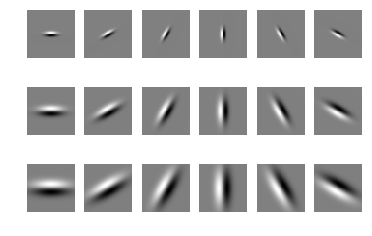

In [11]:
for i in range(0,18):
    plt.subplot(3,6,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i], cmap = 'gray')

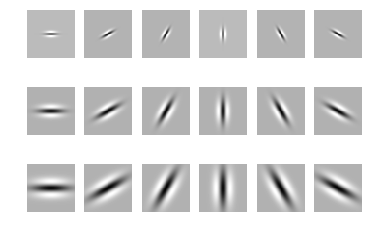

In [12]:
for i in range(0,18):
    plt.subplot(3,6,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i+18], cmap = 'gray')

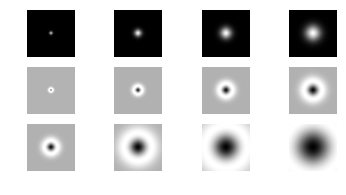

In [13]:
for i in range(0,12):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i+36], cmap = 'gray')

In [14]:
img = cv2.imread("E:/MTECH-IIITB/2018Aug-Dec/DIP-II/MalikSeg_paper/code/BSR/BSDS500/data/images/train/198004.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, dsize=(96, 128), interpolation=cv2.INTER_CUBIC)
img_org = img.copy()

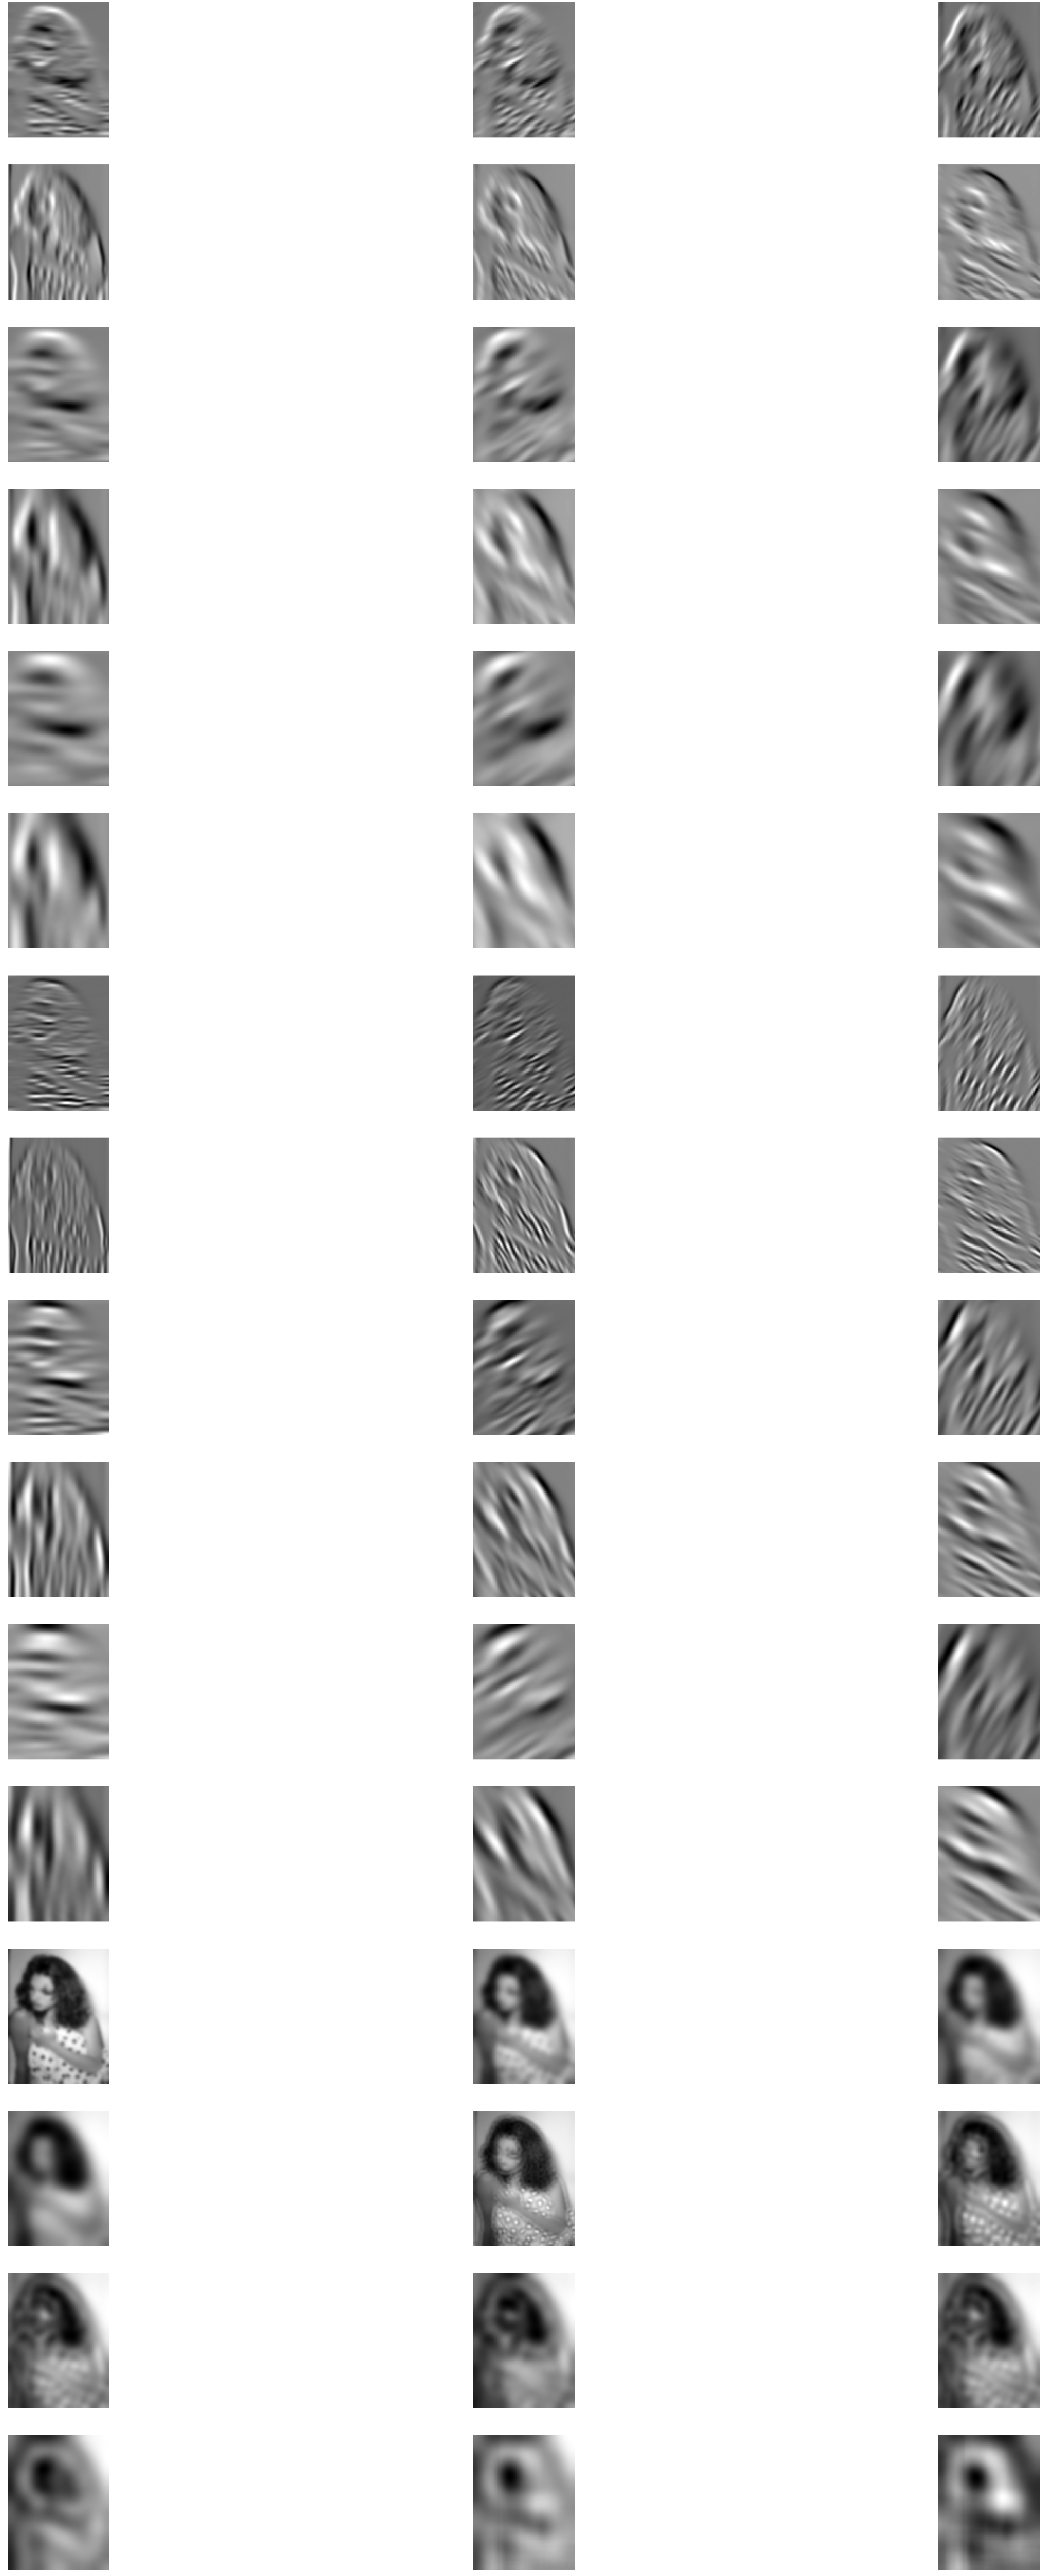

In [15]:
plt.figure(figsize=(100, 200))
hyper_col = np.empty([img.shape[0],img.shape[1],48])
img= np.float32(img)
for i in range(0,48):    
    plt.subplot(16,3,i+1)
    plt.axis('off')
    kernel = F[:,:,i]
    hyper_col[:,:,i] = cv2.filter2D(img,-1,kernel)
    plt.imshow(hyper_col[:,:,i], cmap = 'gray')

(128, 96)


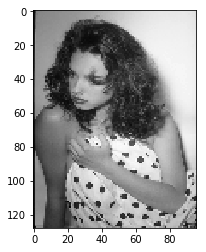

In [16]:

print(img.shape)
plt.imshow(img, cmap='gray')

In [17]:
hyper_col_data = hyper_col.copy().reshape(-1,48)
hyper_col_data = np.float32(hyper_col_data)
print(hyper_col_data.shape)

(12288, 48)


In [18]:
sq_hcd = np.power(hyper_col_data.copy(),2)
sum_sq_hcd = np.sum(sq_hcd,1)
L2_norm_hcd = np.power(sum_sq_hcd,1/2)
norm_factor = np.log10(1+(L2_norm_hcd/0.03))
norm_hyper_col_data = np.empty([hyper_col_data.shape[0],hyper_col_data.shape[1]])
for hi in range(0,hyper_col_data.shape[0]):
    norm_hyper_col_data[hi,:] = (hyper_col_data[hi,:] * norm_factor[hi])/L2_norm_hcd[hi]

In [19]:
norm_hyper_col_data = np.float32(norm_hyper_col_data)
print(hyper_col_data[5])
print(norm_hyper_col_data[5])
print(norm_factor)


[-3.0325622e-15 -2.4615152e+00 -3.6130204e+00 -1.5850046e+00
 -3.6130204e+00 -2.4615152e+00 -2.0574017e-15 -9.1901582e-01
 -2.1449313e+00 -3.6639023e+00 -2.1449313e+00 -9.1901582e-01
 -1.2305261e-15 -7.4008334e-01 -5.4136473e-01 -2.1670496e+00
 -5.4136473e-01 -7.4008334e-01  9.1196477e-01  1.4524021e-02
 -1.7308848e+00 -1.2483754e+00 -1.7308848e+00  1.4524021e-02
  2.9944104e-01  1.7592372e-01 -7.5283080e-02 -1.1540641e+00
 -7.5283080e-02  1.7592372e-01  2.3265867e-02  9.9803537e-02
 -4.2327351e-04 -1.2705794e-01 -4.2327351e-04  9.9803537e-02
  5.1579639e+02  9.9500836e+02  1.4749412e+03  1.9876624e+03
  2.5435175e+02  1.1648078e+02  8.2882866e+01  6.5629944e+01
  8.2882866e+01  4.0041821e+01  1.0973422e+01 -2.3984259e-01]
[-5.4993837e-18 -4.4638216e-03 -6.5520131e-03 -2.8743183e-03
 -6.5520131e-03 -4.4638216e-03 -3.7309845e-18 -1.6665844e-03
 -3.8897141e-03 -6.6442839e-03 -3.8897141e-03 -1.6665844e-03
 -2.2314909e-18 -1.3421002e-03 -9.8173507e-04 -3.9298246e-03
 -9.8173507e-04 -1.3421

In [20]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 36
ret,label,center=cv2.kmeans(norm_hyper_col_data,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

In [21]:
print(center.shape)
print(label.shape)
print(ret)

(36, 48)
(12288, 1)
124.3190244527068


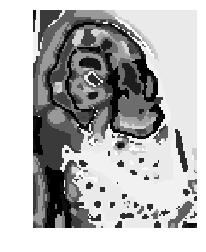

In [22]:
res_img = label.reshape(img.shape[0],img.shape[1])
plt.axis('off')
plt.imshow(res_img, cmap='gray')

In [23]:
from sklearn.preprocessing import scale

In [24]:
F_mat = F.reshape(-1,48) 
F_inv = np.linalg.pinv(F_mat)
textons = np.empty([F.shape[0],F.shape[1],center.shape[0]])
for k in range(0, center.shape[0]):
    cur = center[k,:].reshape(1,48)
    textons_col = F_inv.transpose().dot(cur.transpose())
    textons[:,:,k] = textons_col.reshape(F.shape[0],F.shape[1])
    #cur_textons = (texton-min(texton))/(max(texton-min(texton)))
    #cur_textons = texton#scale(texton, axis=0, with_mean=True, with_std=True, copy=True)
    #print(cur_textons)

In [25]:
minx = np.amin(textons)
maxx = np.amax(textons)
textons = (textons - minx)/(maxx-minx)
print(textons.shape)


(49, 49, 36)


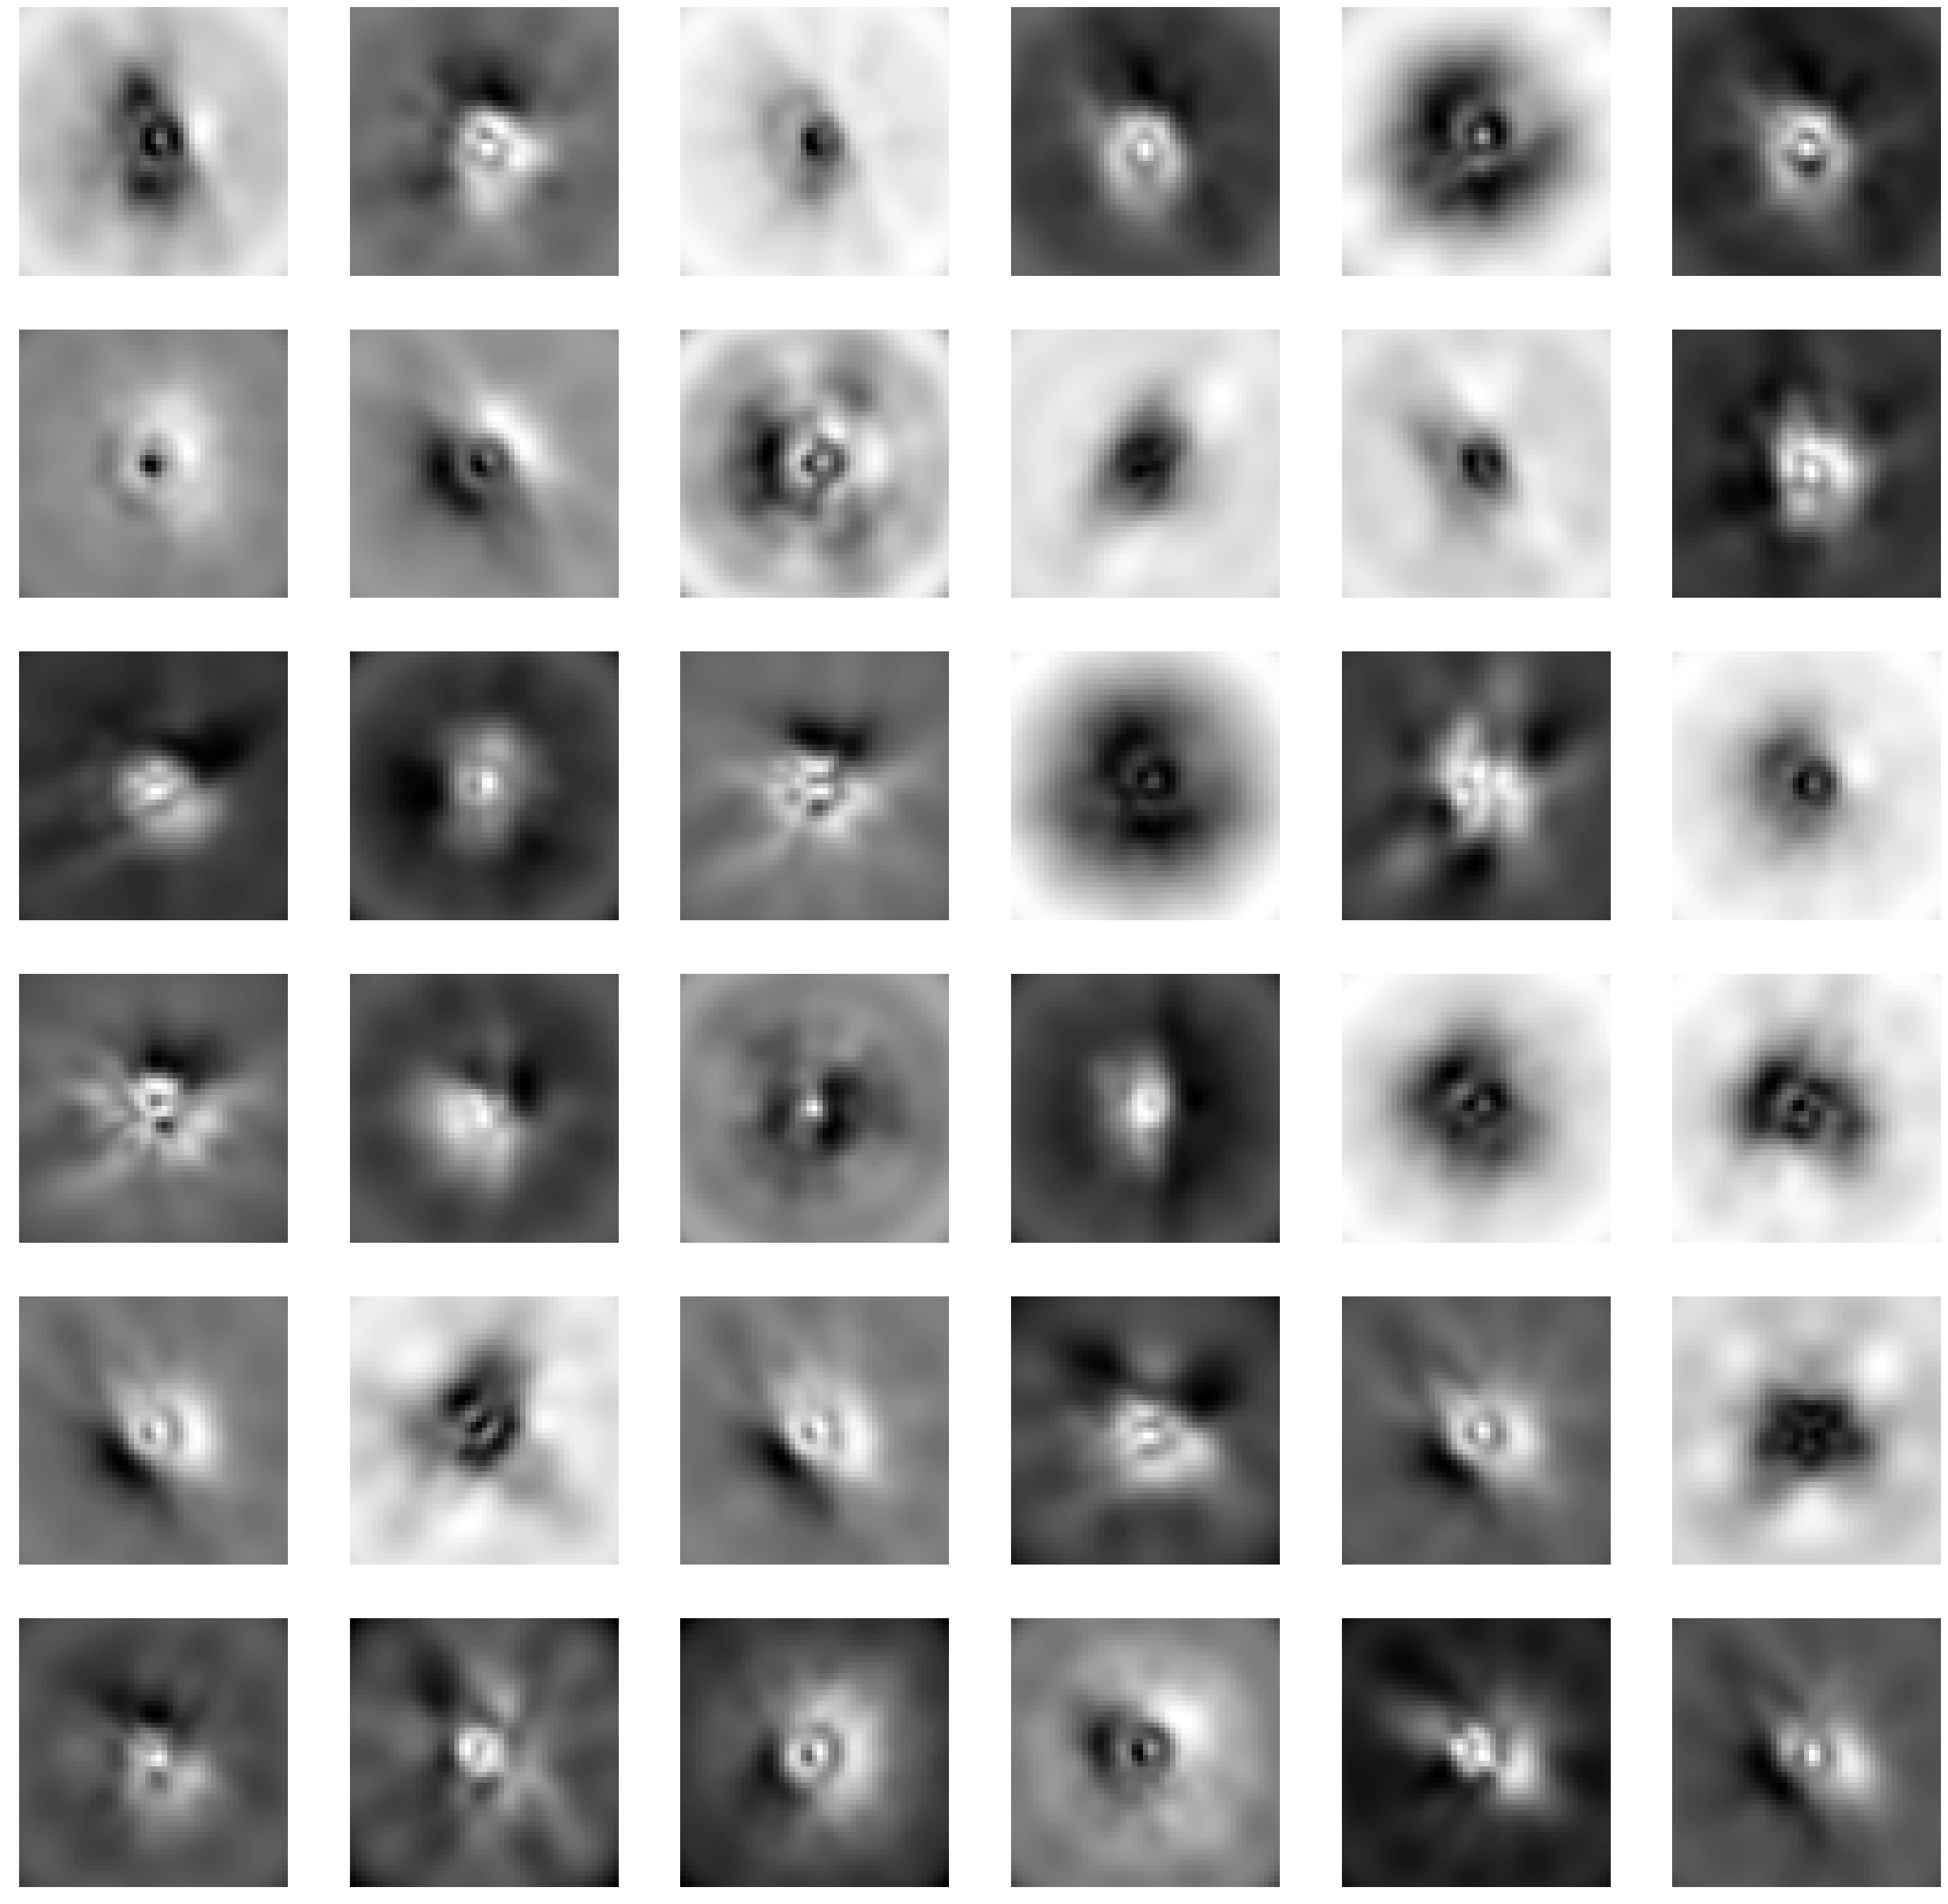

In [26]:
plt.figure(figsize=(49, 49))
for l in range (0,center.shape[0]):
    #print(textons[:,:,l])
    plt.subplot(6,6,l+1)
    plt.axis('off')
    plt.imshow(textons[:,:,l], cmap = 'gray')

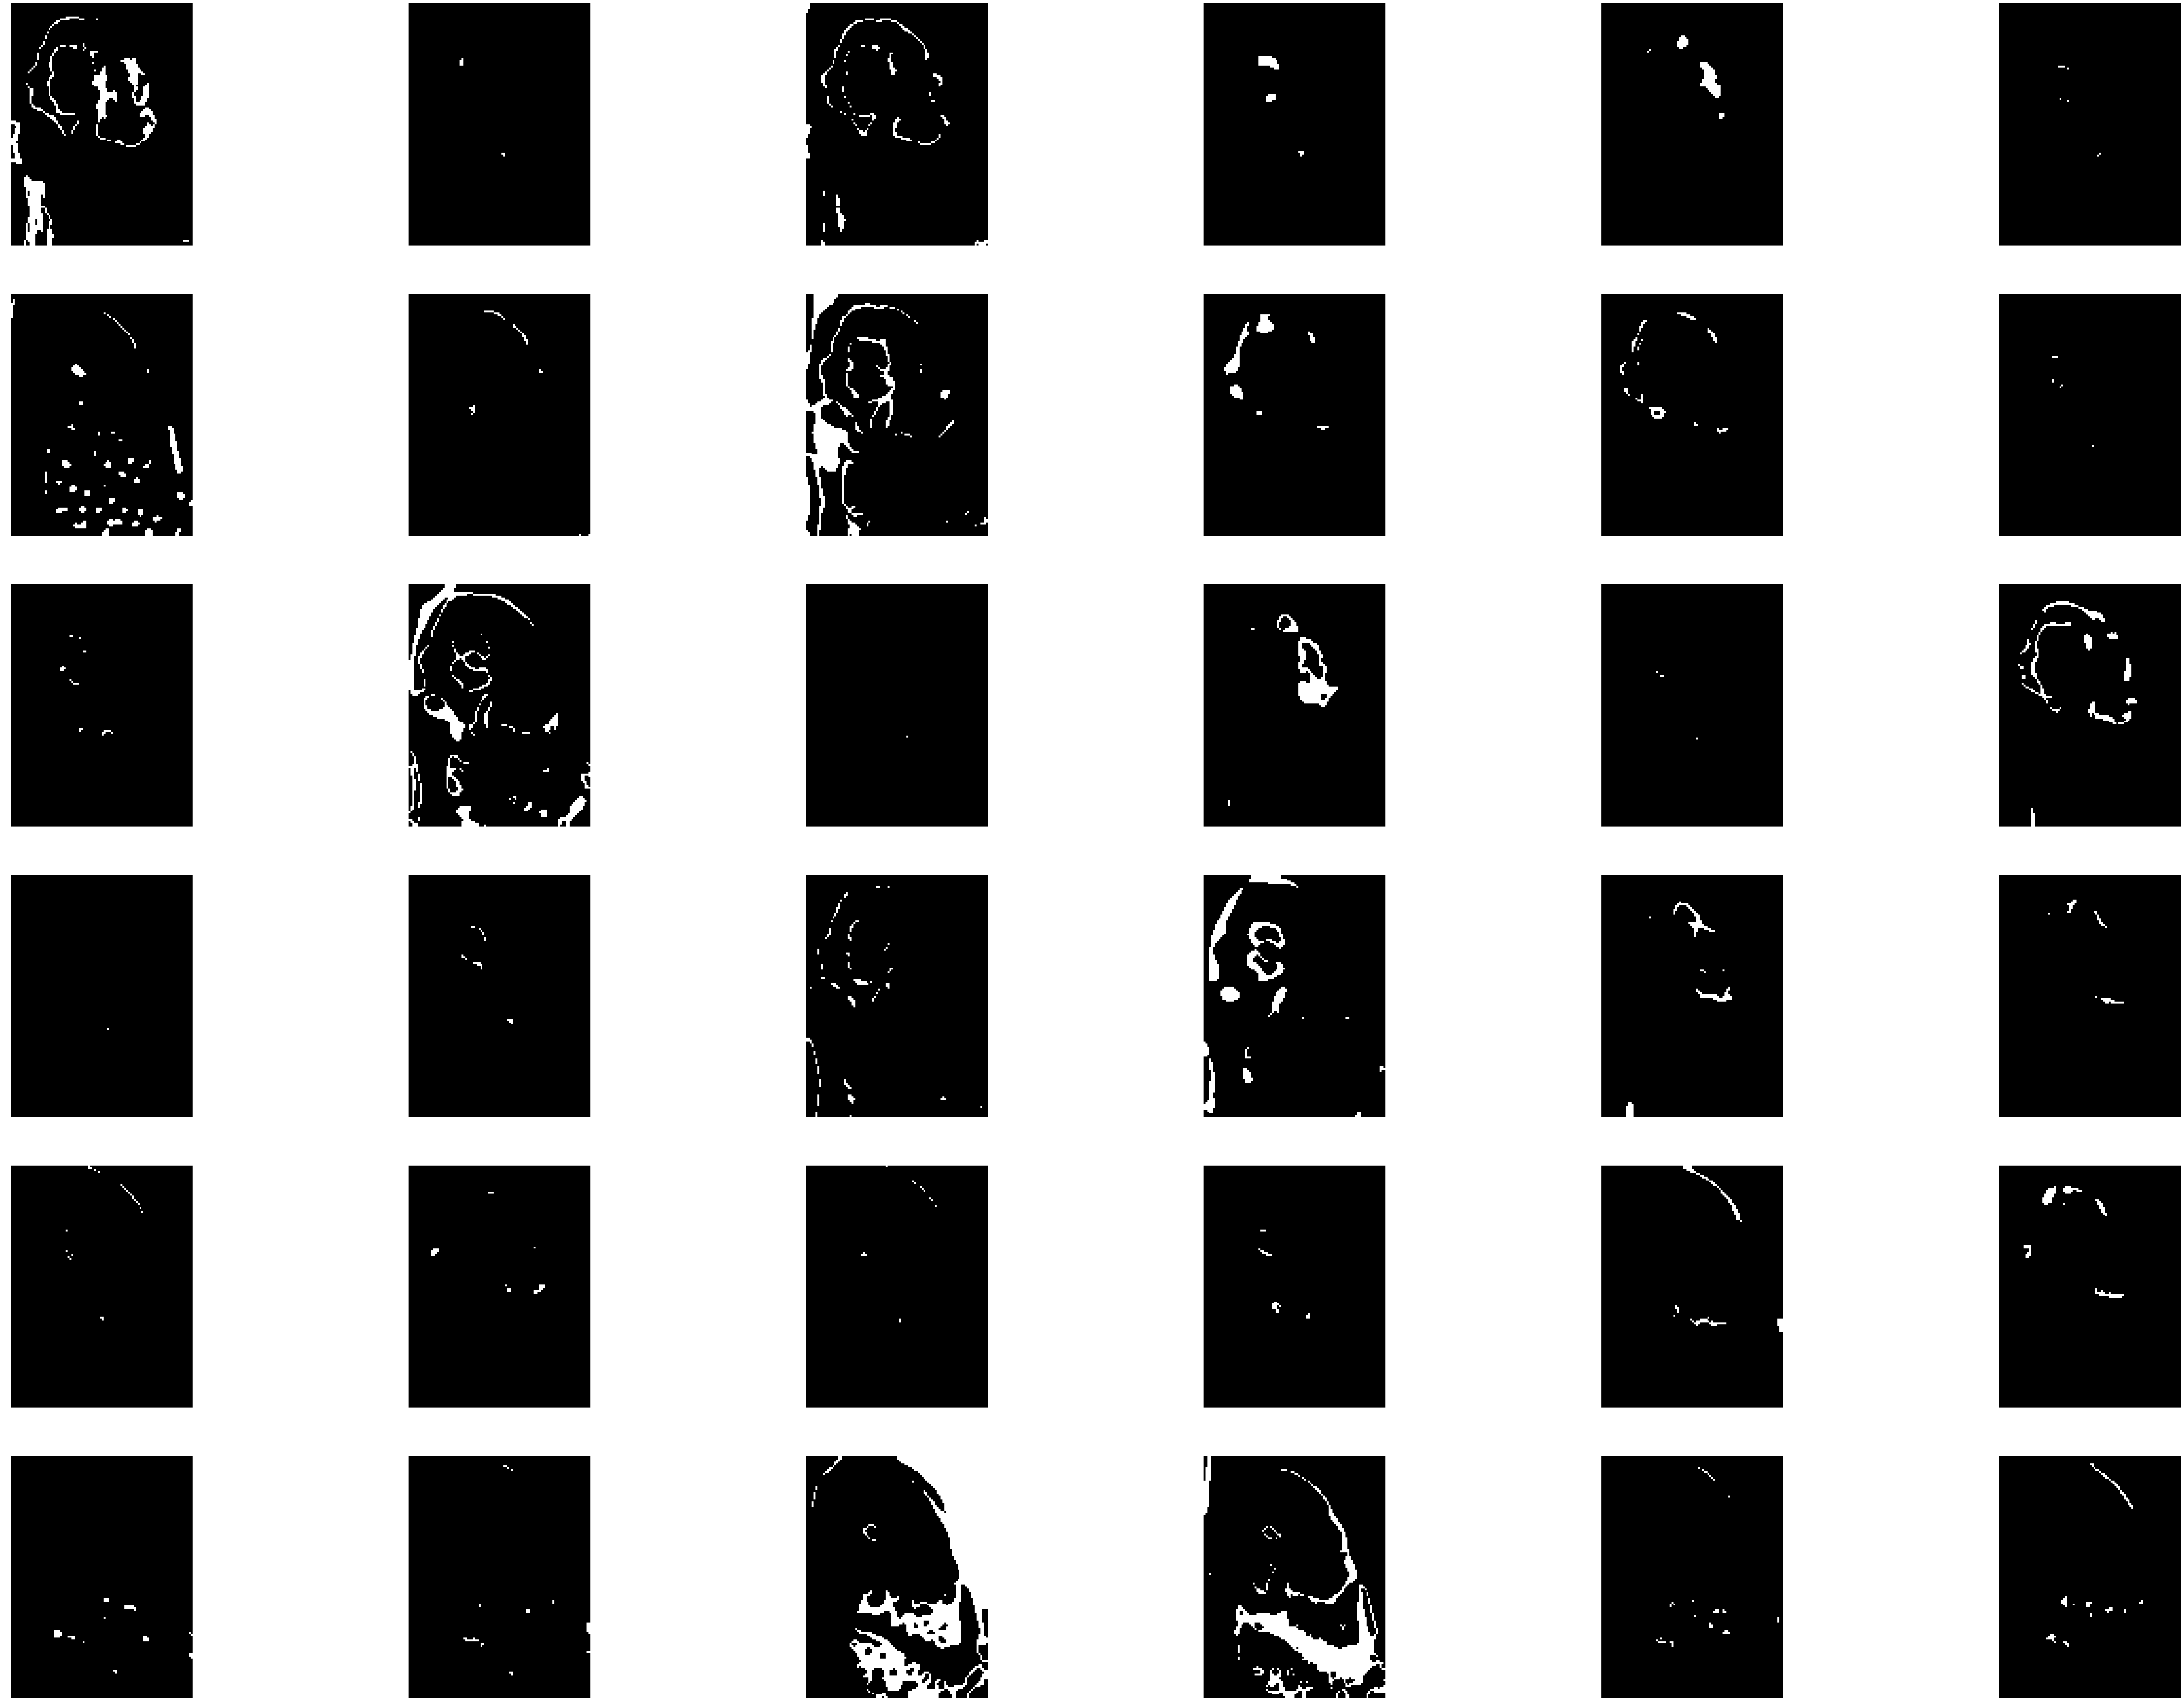

In [27]:
label_img = np.zeros([img.shape[0]*img.shape[1],48])

for i in range(0,img.shape[0]*img.shape[1]):
    label_img[i,label[i]] = 255.0
plt.figure(figsize=(img.shape[0],img.shape[1]))       
for k in range(0,center.shape[0]):
    plt.subplot(6,6,k+1)
    plt.axis('off')
    tmp_l_img = label_img[:,k]
    plt.imshow(tmp_l_img.reshape(img.shape[0],img.shape[1]), cmap='gray')

In [28]:
OE_col = np.empty([img.shape[0]*img.shape[1],18])
OE_col = np.float32(OE_col)
for oei in range(0,18):
    for ii in range(0,img.shape[0]*img.shape[1]):
        OE_col[ii,oei] = np.power(hyper_col_data[ii,oei],2) + np.power(hyper_col_data[ii,oei+18],2)

In [29]:
OE_col_data = np.empty([img.shape[0]*img.shape[1],6])
for oei in range(0,6):
    for ii in range(0,img.shape[0]*img.shape[1]):
        OE_col_data[ii,oei] = OE_col[ii,oei] + OE_col[ii,oei+6] + OE_col[ii,oei+12]

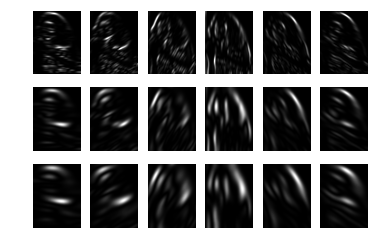

In [30]:
for k in range(0,18):
    plt.subplot(3,6,k+1)
    plt.axis('off')
    plt.imshow(OE_col[:,k].reshape(img.shape[0],img.shape[1]), cmap='gray')

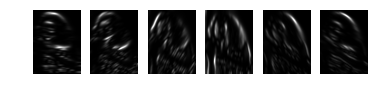

In [31]:
for k in range(0,6):
    plt.subplot(1,6,k+1)
    plt.axis('off')
    plt.imshow(OE_col_data[:,k].reshape(img.shape[0],img.shape[1]), cmap='gray')

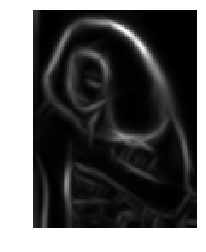

In [32]:
OE_star = np.empty([img.shape[0]*img.shape[1]])
OE_star = np.max(OE_col_data,1)
plt.axis('off')
plt.imshow(OE_star.reshape(img.shape[0],img.shape[1]), cmap='gray')

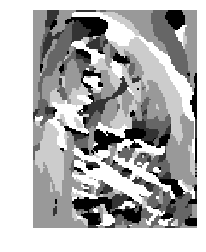

In [33]:
OE_star_ind = np.argmax(OE_col_data,1)
plt.axis('off')
plt.imshow(OE_star_ind.reshape(img.shape[0],img.shape[1]), cmap='gray')

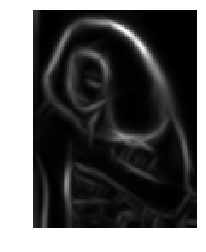

In [34]:
minx = np.amin(OE_star)
maxx = np.amax(OE_star)
OE_star_norm = (OE_star - minx)/(maxx-minx)
plt.axis('off')
plt.imshow(OE_star_norm.reshape(img.shape[0],img.shape[1]), cmap='gray')

In [35]:
neighbour1 = [[-1,0],[-1,-1],[-1,-1],[0,-1],[1,-1],[1,-1]]
neighbour2 = [[1,0],[1,1],[1,1],[0,1],[-1,1],[-1,1]]
#neighbour1 = [[0,-1],[-1,-1],[-1,-1],[-1,0],[-1,1],[-1,1]]
#neighbour2 = [[0,1],[1,1],[1,1],[1,0],[1,-1],[1,-1]]
print(neighbour1[0][:])

[-1, 0]


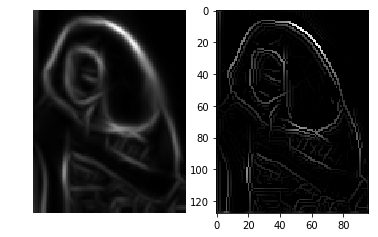

In [36]:
plt.axis('off')
plt.subplot(1,2,1)
plt.imshow(OE_star_norm.reshape(img.shape[0],img.shape[1]), cmap='gray')
OE_ref = OE_star_norm.reshape(img.shape[0],img.shape[1])
OE_img = OE_star.reshape(img.shape[0],img.shape[1])
OE_ind = OE_star_ind.reshape(img.shape[0],img.shape[1])
for idxh in range(1,img.shape[0]-1):
    for idxw in range(1,img.shape[1]-1): 
        if OE_img[idxh,idxw]<OE_img[idxh+neighbour1[OE_ind[idxh,idxw]][0],idxw+neighbour1[OE_ind[idxh,idxw]][1]] or OE_img[idxh,idxw]<OE_img[idxh+neighbour2[OE_ind[idxh,idxw]][0],idxw+neighbour2[OE_ind[idxh,idxw]][1]]:
            OE_img[idxh,idxw]=0.0

plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(OE_img, cmap='gray')

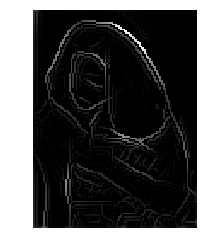

In [37]:
sigma_ic = 1000
OE_img_fact = OE_img/sigma_ic
plt.axis('off')
plt.imshow(OE_img_fact, cmap='gray')

In [38]:
OE_img_fact = OE_img_fact.clip(min=0)
p_con = np.zeros([img.shape[0],img.shape[1]])
p_con = np.float32(p_con)
p_con = 1.0 - np.exp(-OE_img_fact)

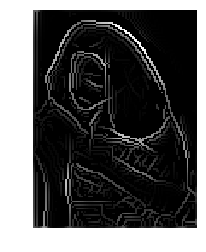

In [39]:
plt.axis('off')
plt.imshow(p_con, cmap='gray')

In [40]:
p_conminx = np.amin(p_con)
p_conmaxx = np.amax(p_con)
print(p_conminx)
print(p_conmaxx)

0.0
0.841750870188883


In [41]:
"""Texturedness"""
def texturedness(hl,hr,h,bins):
    eps = 0.0000000000001
    sigma_tx = 10
    hl_plus = hl+h
    HL = np.power((hl_plus-hr),2)/(hl_plus+hr+eps)
    
    hr_plus = hr+h
    HR = np.power((hr_plus-hl),2)/(hr_plus+hl+eps)
    
    jai_max = max(np.sum(HR),np.sum(HL))/2
    #return jai_max
    return (1-(np.exp((-jai_max-0.3)/100)))

In [43]:
""" Windowed texton histograms"""
p_texture = np.zeros([img.shape[0]*img.shape[1]])
win_rad = 7
for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
        idx = i*img.shape[1] + j
        hr = np.zeros([center.shape[0]])
        hl = np.zeros([center.shape[0]])
        h = np.zeros([center.shape[0]])
        if OE_star_ind[idx] == 0:
            for ii in range(-int(win_rad),0):
                for jj in range(-int(win_rad),int(win_rad)):
                    if i+ii>0 and i+ii<img.shape[0] and j+jj>0 and j+jj<img.shape[1]: 
                        idc = (i+ii)*img.shape[1] + (j+jj)
                        hr[label[idc]] = hr[label[idc]] + 1 
            for ii in range(1,int(win_rad)):
                for jj in range(-int(win_rad),int(win_rad)):
                    if i+ii>0 and i+ii<img.shape[0] and j+jj>0 and j+jj<img.shape[1]: 
                        idc = (i+ii)*img.shape[1] + (j+jj)
                        hl[label[idc]] = hl[label[idc]] + 1
            for jj in range(-int(win_rad),int(win_rad)):
                if j+jj>0 and j+jj<img.shape[1]: 
                    idc = (i)*img.shape[1] + (j+jj)
                    h[label[idc]] = h[label[idc]] + 1
                    
        if OE_star_ind[idx] == 3:
            for ii in range(-int(win_rad),int(win_rad)):
                for jj in range(1,int(win_rad)):
                    if i+ii>0 and i+ii<img.shape[0] and j+jj>0 and j+jj<img.shape[1]: 
                        idc = (i+ii)*img.shape[1] + (j+jj)
                        hr[label[idc]] = hr[label[idc]] + 1 
            for ii in range(-int(win_rad),int(win_rad)):
                for jj in range(-int(win_rad),0):
                    if i+ii>0 and i+ii<img.shape[0] and j+jj>0 and j+jj<img.shape[1]: 
                        idc = (i+ii)*img.shape[1] + (j+jj)
                        hl[label[idc]] = hl[label[idc]] + 1
            for ii in range(-int(win_rad),int(win_rad)):
                if i+ii>0 and i+ii<img.shape[0]: 
                    idc = (i+ii)*img.shape[1] + (j)
                    h[label[idc]] = h[label[idc]] + 1
                    
        elif OE_star_ind[idx] == 4 or OE_star_ind[idx] == 5:
            h_temp = np.zeros([center.shape[0]])
            for ii in range(-int(win_rad),int(win_rad)):
                for jj in range(-int(win_rad),int(win_rad)):
                    if i+ii>0 and i+ii<img.shape[0] and j+jj>0 and j+jj<img.shape[1]: 
                        idc = (i+ii)*img.shape[1] + (j+jj)
                        h_temp[label[idc]] = h_temp[label[idc]] + 1 
            counter = 1
            for ii in range(-int(win_rad),int(win_rad)):
                for jj in range(-int(win_rad),-int(win_rad)+counter):
                    if i+ii!= j+jj and i+ii>0 and i+ii<img.shape[0] and j+jj>0 and j+jj<img.shape[1]: 
                        idc = (i+ii)*img.shape[1] + (j+jj)
                        hl[label[idc]] = hl[label[idc]] + 1
                counter=counter+1
                if counter>int(win_rad):
                    counter = int(win_rad)
            for ii in range(-int(win_rad),int(win_rad)):
                if i+ii>0 and i+ii<img.shape[0] and j+ii>0 and j+ii<img.shape[1]: 
                    idc = (i+ii)*img.shape[1] + (j+ii)
                    h[label[idc]] = h[label[idc]] + 1
            hr = (h_temp - hl)-h
            
        elif OE_star_ind[idx] == 1 or OE_star_ind[idx] == 2:
            h_temp = np.zeros([center.shape[0]])
            for ii in range(-int(win_rad),int(win_rad)):
                for jj in range(-int(win_rad),int(win_rad)):
                    if i+ii>0 and i+ii<img.shape[0] and j+jj>0 and j+jj<img.shape[1]: 
                        idc = (i+ii)*img.shape[1] + (j+jj)
                        h_temp[label[idc]] = h_temp[label[idc]] + 1 
            counter = 1
            for ii in range(-int(win_rad),int(win_rad)):
                for jj in range(-int(win_rad),int(win_rad)-counter):
                    if i+ii!= j+jj and i+ii>0 and i+ii<img.shape[0] and j+jj>0 and j+jj<img.shape[1]: 
                        idc = (i+ii)*img.shape[1] + (j+jj)
                        hl[label[idc]] = hl[label[idc]] + 1
                counter= counter+1
                if counter>int(win_rad):
                    counter = int(win_rad)
            for ii in range(int(win_rad),-int(win_rad),-1):
                if i+ii>0 and i+ii<img.shape[0] and j+ii>0 and j+ii<img.shape[1]: 
                    idc = (i+ii)*img.shape[1] + (j+ii)
                    h[label[idc]] = h[label[idc]] + 1
            hr = (h_temp - hl)-h
            
        p_texture[idx] = texturedness(hl,hr,h,center.shape[0])
        

In [44]:
""" Windowed texton histograms"""
text_hist = np.zeros([img.shape[0]*img.shape[1],center.shape[0]+1])
print(text_hist.shape)
p_con_flat = p_con.copy()
p_con_flat = p_con_flat.reshape(-1,1) 
win_rad = 7
for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
        for ii in range(-int(win_rad),int(win_rad)):
            for jj in range(-int(win_rad),int(win_rad)):
                if i+ii>0 and i+ii<img.shape[0] and j+jj>0 and j+jj<img.shape[1]: 
                    idx = i*img.shape[1] + j
                    idc = (i+ii)*img.shape[1] + (j+jj)
                    if p_con_flat[idc]>0.05:
                        text_hist[idx][label[idc]] = text_hist[idx][label[idc]] + 1*p_texture[idx]
                        text_hist[idx][center.shape[0]] = text_hist[idx][center.shape[0]] + (1-p_texture[idx])
                    else:
                        text_hist[idx][center.shape[0]] = text_hist[idx][center.shape[0]] + 1
        
    

(12288, 37)


In [45]:
def tex_similarity(hi,hj,bins):
    eps = 0.000001
    sigma_tx = 10
    hr = np.power((hi-hj),2)/(hi+hj+eps)
    return np.exp(-((np.sum(hr)/2)/10))

In [46]:
img_i = img_org.copy()
img_i = np.int32(img_i.reshape(img.shape[0]*img.shape[1]))
g_tx = graph.rag.RAG()
for ix in range(0,img.shape[0]*img.shape[1]):
    g_tx.add_node(ix,labels=[img_i[ix]])
win_rad = 7
for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
        for ii in range(-int(win_rad),int(win_rad)):
            for jj in range(-int(win_rad),int(win_rad)):
                if i+ii>0 and i+ii<img.shape[0] and j+jj>0 and j+jj<img.shape[1]: 
                    idx = i*img.shape[1] + j
                    idc = (i+ii)*img.shape[1] + (j+jj)
                    w_tx = tex_similarity(text_hist[idx,:],text_hist[idc,:],center.shape[0])
                    g_tx.add_edge(idx, idc, weight=w_tx)
    


In [47]:
def intervening_contour(p_con,sx,sy,tx,ty):
    if sx>=p_con.shape[0] or sy>=p_con.shape[1] or tx>=p_con.shape[0] or ty>=p_con.shape[1]:
        return -1.0
    if sx<0 or sy<0 or tx<0 or ty<0:
        return -1.0
    dx=np.absolute(sx-tx)
    dy=np.absolute(sy-ty)
    #print(dx)
    #print(dy)
    st = int(max(dx,dy)/max(min(dx,dy),1))
    if st==0:
        st = 1
    #print(st)
    if sx<tx :
        dir_x = -1
    else :
        dir_x = 1
    if sy<ty :
        dir_y = -1
    else :
        dir_y = 1
    if(dx>dy):
        dx = st
        dy = 1
    else:
        dx = 1
        dy = st
    cx=tx
    cy=ty
    max_p = 0.0
    if sx<tx and sy<ty:
        while sx<cx or sy<cy:
            if max_p<p_con[cx,cy]:
                max_p = p_con[cx,cy]
            if sx<cx :
                cx = cx + dir_x*dx
            if sy<cy :
                cy = cy + dir_y*dy
            if sx>=cx and sy>=cy:
                break
            #print('cx '+str(cx)+' cy '+str(cy))
    elif sx>=tx and sy>=ty:
        while sx>=cx or sy>=cy:
            if max_p<p_con[cx,cy]:
                max_p = p_con[cx,cy]
            if sx>cx :
                cx = cx + dir_x*dx
            if sy>cy :
                cy = cy + dir_y*dy
            if sx<=cx and sy<=cy:
                break        
            #print('cx '+str(cx)+' cy '+str(cy))
    elif sx<tx and sy>=ty:
        while sx<cx or sy>=cy:
            if max_p<p_con[cx,cy]:
                max_p = p_con[cx,cy]
            if sx<cx :
                cx = cx + dir_x*dx
            if sy>cy :
                cy = cy + dir_y*dy
            if sx>=cx and sy<=cy:
                break
            #print('cx '+str(cx)+' cy '+str(cy))
    elif sx>=tx and sy<ty:
        while sx>=cx or sy<cy:
            if max_p<p_con[cx,cy]:
                max_p = p_con[cx,cy]
            if sx>cx :
                cx = cx + dir_x*dx
            if sy<cy :
                cy = cy + dir_y*dy
            if sx<=cx and sy>=cy:
                break
            #print('cx '+str(cx)+' cy '+str(cy))
    return (1-max_p)
            

In [48]:

p_con_gated = p_con * (1-p_texture.reshape(img.shape[0],img.shape[1]))
g_ic = graph.rag.RAG()
for ix in range(0,img.shape[0]*img.shape[1]):
    g_ic.add_node(ix,labels=[img_i[ix]])
win_rad = 7
for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
        for ii in range(-int(win_rad),int(win_rad)):
            for jj in range(-int(win_rad),int(win_rad)):
                if i+ii>0 and i+ii<img.shape[0] and j+jj>0 and j+jj<img.shape[1]: 
                    idx = i*img.shape[1] + j
                    idc = (i+ii)*img.shape[1] + (j+jj)
                    w_tx = intervening_contour(p_con_gated,i,j,i+ii,j+jj)
                    g_ic.add_edge(idx, idc, weight=w_tx)

In [49]:

g_seg = graph.rag.RAG()
for ix in range(0,img.shape[0]):
    for iy in range(0,img.shape[1]):
        idx = ix*img.shape[1] + iy
        g_seg.add_node(idx,labels=[label[idx]])
win_rad = 7
for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
        for ii in range(-int(win_rad),int(win_rad)):
            for jj in range(-int(win_rad),int(win_rad)):
                if i+ii>0 and i+ii<img.shape[0] and j+jj>0 and j+jj<img.shape[1]: 
                    idx = i*img.shape[1] + j
                    idc = (i+ii)*img.shape[1] + (j+jj)
                    w_tx = g_tx[idx][idc]['weight']
                    w_ic = g_ic[idx][idc]['weight']
                    g_seg.add_edge(idx, idc, weight=(w_tx*w_ic))

In [50]:
labels3 = graph.cut_normalized(label.reshape(img.shape[0],img.shape[1]), g_seg,1,18)

C:\Program Files\Anaconda3\lib\site-packages\skimage\future\graph\graph_cut.py:136: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  map_array[d['labels']] = d['ncut label']


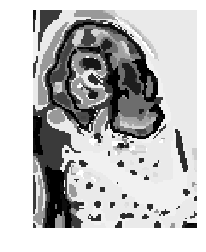

In [51]:
cut_img = labels3.reshape(img.shape[0],img.shape[1])
plt.axis('off')
plt.imshow(cut_img,cmap='gray')
#print(cut_img)

# Results end here!! next are just random experiments!!

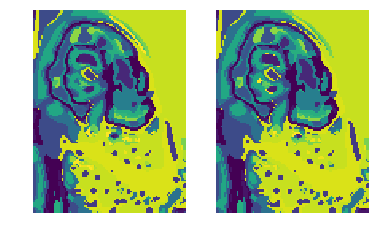

In [100]:
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(label.reshape(img.shape[0],img.shape[1]))
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(cut_img)

In [86]:
for i in range(0,img.shape[0]*img.shape[1]):
    g_seg.node[i]['labels'] = [g_seg.node[i]['ncut label']]
labels3 = graph.cut_normalized(cut_img, g_seg,100000000000,32)
cut_img = labels3.reshape(img.shape[0],img.shape[1])
plt.axis('off')
plt.imshow(cut_img)

KeyboardInterrupt: 

In [61]:
#for n, d in g_seg.nodes(data=True):
#    print(d)

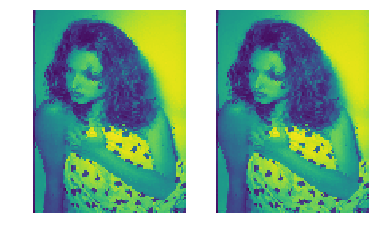

In [67]:
#for n, d in g_seg.nodes(data=True):
label_img = np.empty([img.shape[0]*img.shape[1]])
for i in range(0,img.shape[0]*img.shape[1]):
    label_img[i] = g_seg.node[i]['ncut label']
cut_img = label_img.reshape(img.shape[0],img.shape[1])
org_img = np.empty([img.shape[0]*img.shape[1]])
for i in range(0,img.shape[0]*img.shape[1]):
    org_img[i] = g_seg.node[i]['ncut label']
org_img = org_img.reshape(img.shape[0],img.shape[1])

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(org_img)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(cut_img)

In [55]:
l=0
img_i = img_org.copy()
img_i = np.int32(img_i.reshape(img.shape[0]*img.shape[1]))
g = graph.rag.RAG()
for ix in range(0,img.shape[0]*img.shape[1]):
    g.add_node(ix,labels=[img_i[ix]])

for ix in range(0,img.shape[0]*img.shape[1]):
    for jy in range(ix-5,ix+5):
        if jy<0:
            jy=0
        if jy>img.shape[0]*img.shape[1]-1:
            jy=img.shape[0]*img.shape[1]-1
        g.add_edge(ix, jy, weight=l)
        l=l+1
        if l>32:
            l=0
        
print(g.node[1]['labels'])
labels2 = graph.cut_normalized(img_i, g,1.0,16)

[83]


In [59]:
print(labels2)

[158 204 118 ... 170  54  54]


In [73]:
print(text_hist[500])

[ 6.  0.  5.  0.  0.  0.  0.  0. 24.  0.  0.  0.  0. 83.  0.  0.  0.  2.
  0.  0.  4. 21.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.  0.  0.]


In [76]:
print(tex_similarity(text_hist[500,:],text_hist[505,:],center.shape[0]))

0.3005297880544976


In [67]:
intervening_contour(p_con,91,81,100,35)

0.8738497470155473

In [129]:
print(g_tx.node[100]['labels'])
print(g_tx[100][101]['weight'])
print(g_ic.node[100]['labels'])
print(g_ic[100][101]['weight'])

[145]
0.9349075401331062
[145]
0.9399650598624046


In [123]:
labels1 = segmentation.slic(img_i.reshape(img.shape[0],img.shape[1]), compactness=30, n_segments=200)


C:\Program Files\Anaconda3\lib\site-packages\skimage\segmentation\slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
C:\Program Files\Anaconda3\lib\site-packages\skimage\segmentation\slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
C:\Program Files\Anaconda3\lib\site-packages\skimage\segmentation\slic_superpixels.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `ar

(128, 96)


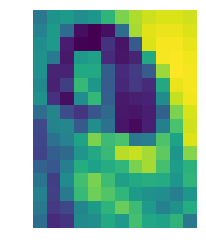

In [124]:
out1 = color.label2rgb(labels1, img_i.reshape(img.shape[0],img.shape[1]), kind='avg')
plt.axis('off')
plt.imshow(out1)
print(labels1.shape)

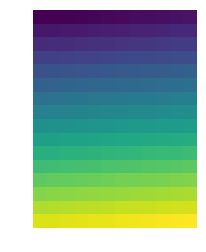

In [127]:
ncut_img = labels3
plt.axis('off')
plt.imshow(ncut_img)

In [100]:
print(np.amax(labels3))

34


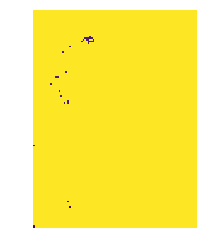

In [103]:
out2 = color.label2rgb(labels3, img_i, kind='avg')
plt.axis('off')
plt.imshow(out2.reshape(img.shape[0],img.shape[1]))

In [133]:
g_seg

In [453]:
p_texture = p_texture-np.median(p_texture)
p_texture.clip(0,1)

array([0., 0., 0., ..., 0., 0., 0.])

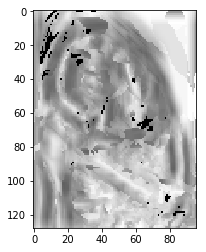

In [454]:
plt.imshow((1-(p_texture)).reshape(img.shape[0],img.shape[1]),cmap='gray')

In [430]:
p_texture[9100]

24.4715037593983

In [445]:
p_val = p_texture[2390]
print(p_val)
print(1-(np.exp((-p_val-0.3)/100)))
print(1 - 1/((np.exp(-(((p_val)-5)/20)))+0.000001))

12.499999999999993
0.1201466208553561
-0.4549892976212644


In [458]:
np.max(p_texture)

0.676436783721091